## **Install packages**

---



In [ ]:
# %pip install openai
# %pip install bertopic
# %pip install tiktoken
# %pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
# %pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
# %pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
# %pip install --upgrade cupy-cuda12x -f https://pip.cupy.dev/aarch64
# %pip install --upgrade firebase-admin --user
# %pip install torch --user

Use this if there are some dependencies error

In [ ]:
# !pip uninstall -y cupy-cuda11x
# !pip uninstall -y cupy-cuda12x
# !pip uninstall -y cuda-python
# !pip install --upgrade cuda-python

##  **Import libraries**

---



In [1]:
# Data manipulation
import pandas as pd

# Regex
import re

# OpenAI Library
import openai

# Graphs
import matplotlib.pyplot as plt
# from wordcloud import WordCloud

# GPU support and tensor operations
import torch

## Dimensionality reduction
from umap import UMAP

# Dimensionality reduction using GPU
# from cuml.manifold import UMAP

## Clustering
from hdbscan import HDBSCAN

# Clustering using GPU
# from cuml.cluster import HDBSCAN

# Read environment variables
from os import getenv

# Sentence embeddings
from sentence_transformers import SentenceTransformer

# Text vectorization
from sklearn.feature_extraction.text import CountVectorizer

# Topic modeling
from bertopic import BERTopic

# Custom representation for topics
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech, OpenAI

# Document tokenizer for ai representation
import tiktoken

# Custom vectorizer for class-baseD TF-IDF
from bertopic.vectorizers import ClassTfidfTransformer

# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Access colab env
# from google.colab import userdata

## **Data Import and Environment Setup**

---



Import data from a CSV file, combine relevant columns.

In [2]:
# Import data from CSV file
subreddits = ["ArtificialInteligence", "MachineLearning", "artificial"]
df = pd.concat([pd.read_csv(f"../backend/data/{subreddit}.csv") for subreddit in subreddits])

# remove rows with empty body and title
df = df.dropna(subset=["body", "title"])
df = df.reset_index(drop=True)

# Create a new DataFrame with combined title and body text
df["text"] = df["title"] + " " + df["body"]

print(f"Data has been imported. There are {len(df)} rows.")

Data has been imported. There are 1389 rows.


Initialize OpenAI Client

In [3]:
client = openai.OpenAI(api_key=getenv('OPENAI_API_KEY'))

response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a helpful, respectful and honest assistant for labeling topics."},
    {"role": "user", "content": "Hello!"}
  ]
)

print(response.choices[0].message.content)

Hello! How can I assist you today?


In [4]:
prompt = """
You are a helpful, respectful and honest assistant for labeling topics.

Given this example input:
I have a topic that contains the following documents:
 - Traditional diets in most cultures were primarily plant-based with a little meat on top, but with the rise of industrial style meat production and factory farming, meat has become a staple food.
 - Meat, but especially beef, is the word food in terms of emissions.
 - Eating meat doesn't make you a bad person, not eating meat doesn't make you a good one.
The topic is described by the following keywords: 'meat, beef, eat, eating, emissions, steak, food, health, processed, chicken'.
Based on the information about the topic above, please create a short but broad and highly encompassing label of this topic, focus on the keywords. Make sure you to only return the label and nothing more.

Your reply as the assistant is:
topic: Environmental impacts of eating meat.

Given the example above, now do this:
I have a topic that contains the following documents:
[DOCUMENTS]
The topic is described by the following keywords: [KEYWORDS]

Based on the information above, extract a short yet highly encompassing topic label of at most 10 words. Make sure it is in the following format:
topic: <topic label>
"""

## **Data Preprocessing**

---



Remove links from text

In [5]:
df["text"] = df["text"].str.replace(r"http\S+", "", regex=True)
df["text"] = df["text"].str.replace(r"www.\S+", "", regex=True)

Remove extra spaces, leading and trailing spaces

In [6]:
df["text"] = df["text"].str.replace(r" +", " ")
df["text"] = df["text"].str.strip()

Replace consecutive zeroes with a single zero.

In [7]:
def remove_consecutive_zeros(text):
    # Use regex to replace multiple consecutive 0s with a single 0
    return re.sub(r'0+', '0', text)

df['text'] = df['text'].apply(remove_consecutive_zeros)

We will use `docs` as our main working dataset.

In [8]:
docs = df["text"]
titles = df["title"]



## **Setup BERTopic Layers**

---



**Step 1 - Extract embeddings**

Other Sentence Transformer can be found in this [leaderboard](https://huggingface.co/spaces/mteb/leaderboard)

In [9]:
# embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embedding_model = SentenceTransformer("thenlper/gte-small", trust_remote_code=True)
# embedding_model = SentenceTransformer("avsolatorio/NoInstruct-small-Embedding-v0")

Pre-calculate embeddings to save time.

In [10]:
embeddings = embedding_model.encode(docs, show_progress_bar=True)

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

**Step 2 - Reduce dimensionality**

In [11]:
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=21522)

**Step 3 - Cluster reduced embeddings**

In [31]:
hdbscan_model = HDBSCAN(min_cluster_size=20, min_samples=3, metric='euclidean', cluster_selection_method='leaf', prediction_data=True)

**Step 4 - Tokenize topics**

In [13]:
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))

**Step 5 - Create topic representation**

In [14]:
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)

**Step 6 - Fine-tune topic representations**

In [15]:
# KeyBERT Inspired
keybert_model = KeyBERTInspired(top_n_words=10)

# Maximal Marginal Relevance
mmr_model  = MaximalMarginalRelevance(top_n_words=10, diversity=0.3)

# Part-of-Speech
pos_model  = PartOfSpeech(top_n_words=10, model="en_core_web_sm")

# Open AI
openai_tokenizer = tiktoken.encoding_for_model("gpt-3.5-turbo")
openai_model  = OpenAI(client, model="gpt-3.5-turbo", exponential_backoff=True, chat=True, prompt=prompt, nr_docs=10, doc_length=200, tokenizer=openai_tokenizer)

# Create dictionary
representation_model = {
    "KeyBERT": keybert_model,
    "MMR": mmr_model,
    "POS": pos_model,
    "OpenAI": [pos_model, openai_model],
}

## **Create the Model**

---



In [22]:
topic_model = BERTopic(
  # Pipeline models
  embedding_model=embedding_model,            # Step 1 - Extract embeddings
  umap_model=umap_model,                      # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,                # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,          # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                  # Step 5 - Extract topic words
  representation_model=representation_model,  # Step 6 - Fine-tune topic represenations

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

## **Start Model Training**

---



In [23]:
topics, probs = topic_model.fit_transform(docs, embeddings)

2024-06-04 10:04:24,304 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


2024-06-04 10:04:27,384 - BERTopic - Dimensionality - Completed ✓
2024-06-04 10:04:27,386 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-04 10:04:27,427 - BERTopic - Cluster - Completed ✓
2024-06-04 10:04:27,432 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 52/52 [00:41<00:00,  1.26it/s]
2024-06-04 10:05:56,078 - BERTopic - Representation - Completed ✓


## **Results**

Get number of topics

In [24]:
topic_length = len(topic_model.get_topic_info()) - 1
print(f"Topics have been created. There are {topic_length} topics.")

Topics have been created. There are 51 topics.


Update topic label to ChatGPT result

In [25]:
chatgpt_topic_labels = {topic: " | ".join(list(zip(*values))[0]) for topic, values in topic_model.topic_aspects_["OpenAI"].items()}
chatgpt_topic_labels[-1] = "Outlier Topic"
topic_model.set_topic_labels(chatgpt_topic_labels)

In [26]:
topic_model.get_topic_info()

,Topic,Count,Name,CustomName,Representation,KeyBERT,MMR,POS,OpenAI,Representative_Docs
0,-1,451,-1_user_prompt_agents_real,Outlier Topic,"[user, prompt, agents, real, data, knowledge, ...","[ai agents, ai systems, reinforcement learning...","[user, prompt, agents, real, data, knowledge, ...","[user, prompt, agents, real, data, knowledge, ...",[Ethics of AI agents and data management.],[AI Censorship Conversation with Llama 3 8B A ...
1,0,48,0_excel_good ai_ai tool_documents,Developing AI assistant for automating custome...,"[excel, good ai, ai tool, documents, looking a...","[ai tools, ai tool, using ai, ai needs, ai mod...","[excel, good ai, ai tool, documents, looking a...","[documents, tools, help, files, blueprint, inf...",[Developing AI assistant for automating custom...,[Is there an AI that automatically creates mac...
2,1,39,1_openai_altman_sam_sam altman,Developments and Challenges at OpenAI,"[openai, altman, sam, sam altman, google, comp...","[open ai, openai, openai ceo, google ai, opena...","[openai, altman, sam, sam altman, google, comp...","[company, fun, board, reddit, deal, team, par,...",[Developments and Challenges at OpenAI],[OpenAI Is 'Exploring' How to Responsibly Gene...
3,2,34,2_validation_loss_torch_knn,AI model evaluation and improvement utilizing ...,"[validation, loss, torch, knn, self, probabili...","[regression, model architecture, model, output...","[validation, loss, torch, knn, self, probabili...","[validation, loss, torch, knn, self, probabili...",[AI model evaluation and improvement utilizing...,[[P] From Scrath PPO Implementation. I've been...
4,3,33,3_nlp_litellm_language_large language,Evolving applications of Large Language Models,"[nlp, litellm, language, large language, spacy...","[llms ai, natural language, language models, p...","[nlp, litellm, language, large language, spacy...","[language, large language, historical, reputat...",[Evolving applications of Large Language Models],[LIMINAL: Making History Experiential I'm Marc...
5,4,32,4_consciousness_humans_humanity_intelligence,The Role of Humanity in the Age of AI,"[consciousness, humans, humanity, intelligence...","[human intelligence, intelligence, intelligent...","[consciousness, humans, humanity, intelligence...","[consciousness, humans, humanity, intelligence...",[The Role of Humanity in the Age of AI],[Humanity's Role in an AI-Dominated World: A D...
6,5,31,5_degree_career_science_computer science,Career transition into AI and machine learning.,"[degree, career, science, computer science, ma...","[learn ai, learning ai, ai courses, incorporat...","[degree, career, science, computer science, ma...","[degree, career, science, master, courses, sta...",[Career transition into AI and machine learning.],[[D] The Dilemma of Taking Notes on Every ML R...
7,6,29,6_4o_gpt 4o_gpt_chatgpt,Impact of ChatGPT on Homework Assistance Industry,"[4o, gpt 4o, gpt, chatgpt, care, having ai, ap...","[chatgpt 4o, chatgpt, use chatgpt, using chatg...","[4o, gpt 4o, gpt, chatgpt, care, having ai, ap...","[4o, gpt, chatgpt, app, homework, messages, us...",[Impact of ChatGPT on Homework Assistance Indu...,[Auggie: A GPT-4o assistant on your desktop fo...
8,7,27,7_ai video_videos_video_editing,AI tools for efficient video creation and editing,"[ai video, videos, video, editing, maker, vide...","[ai video, video editing, ai tool, create vide...","[ai video, videos, video, editing, maker, vide...","[videos, video, editing, maker, pictures, bird...",[AI tools for efficient video creation and edi...,[Ai tools to reduce time needed for editing an...
9,8,26,8_optional_int_alpha_false,Lightweight Computer Vision Models for Efficie...,"[optional, int, alpha, false, checks, image, b...","[vision models, computer vision, detection mod...","[optional, int, alpha, false, checks, image, b...","[optional, int, alpha, checks, image, bytes, o...",[Lightweight Computer Vision Models for Effici...,[[D] Has anyone worked with rembg (python)? ...


In [35]:
#%pip install nbformat
# install wordcloud
%pip install wordcloud

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [27]:
import nbformat as nbf
# import wordcloud
from wordcloud import WordCloud

In [28]:
topic_model.visualize_term_rank()




Topic 1


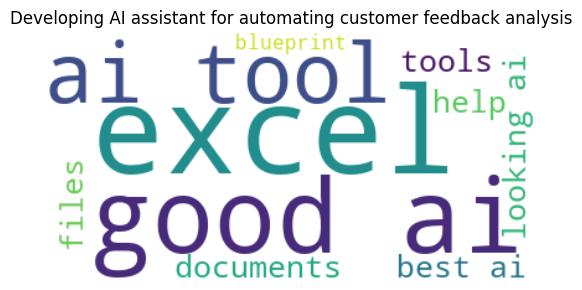



Topic 2


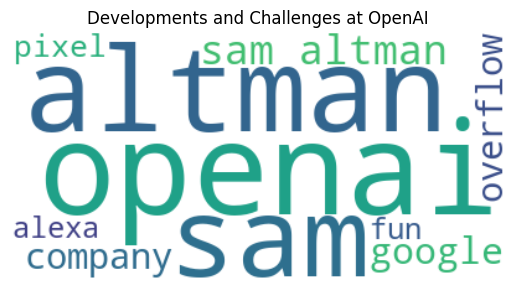



Topic 3


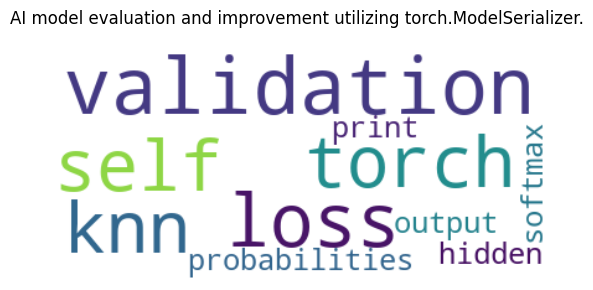



Topic 4


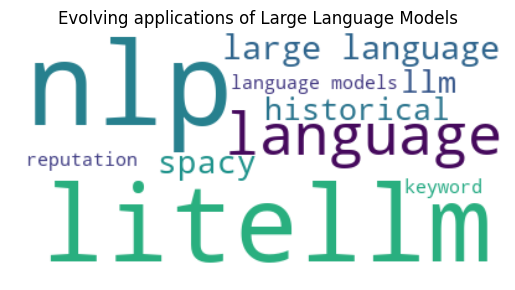



Topic 5


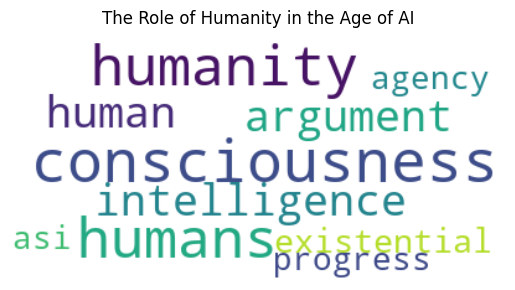

In [29]:
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=100)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topic_model.get_topic_info()["CustomName"][topic+1])
    plt.show()

# Show wordcloud for topics
for i in range(0,5):
    print("Topic", i+1)
    create_wordcloud(topic_model, topic=i)
    print("\n")

In [30]:
topic_model.visualize_topics(custom_labels=True)

In [32]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, custom_labels=True, hide_annotations=True)

In [33]:
topic_model.visualize_hierarchy(custom_labels=True)

In [42]:
for i in range(0,topic_length):
    topics = topic_model.get_topic(i, full=True)
    res_keybert = [topics["KeyBERT"][j][0] for j in range(10)]
    res_mmr = [topics["MMR"][j][0] for j in range(10)]
    res_pos = [topics["POS"][j][0] for j in range(10)]
    res_openai = topics["OpenAI"][0][0]
    print("Topic ", i+1)
    print("KeyBERT: ",res_keybert)
    print("MMR: ",res_mmr)
    print("POS: ",res_pos)
    print("OpenAI: ",res_openai)
    print("=" * 50,"\n")

Topic  1
KeyBERT:  ['ai chatbot', 'chatbots', 'meta ai', 'chatbot', 'chat bot', 'conversational ai', 'bot', 'robot', 'bots', 'robots']
MMR:  ['app', 'chatgpt', 'meta', 'chat', 'chatbots', 'meta ai', 'apps', 'jan', 'chatbot', 'entities']
POS:  ['app', 'chatgpt', 'meta', 'chat', 'chatbots', 'apps', 'chatbot', 'entities', 'api', 'conversational']
OpenAI:  Conversational AI Applications and Meta-Analysis

Topic  2
KeyBERT:  ['ai news', 'new ai', 'ai', 'ai model', 'artificial intelligence', 'ai startup', 'ai applications', 'generative ai', 'openai', 'google openai']
MMR:  ['nvidia', 'chips', 'details', 'billion', 'ai news', 'chip', '2024', 'news', 'microsoft', 'openai']
POS:  ['chips', 'chip', 'news', 'minute', 'artificial intelligence', 'artificial', 'generative', 'chatbot', 'new', 'intelligence']
OpenAI:  Advancements in Artificial Intelligence Chip Technology

Topic  3
KeyBERT:  ['use ai', 'working ai', 'learn ai', 'ai skills', 'ai tools', 'learning ai', 'ai', 'ai looking', 'ai personal'